In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Dropout, SimpleRNN, LSTM, Bidirectional, GRU,BatchNormalization, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import gensim.downloader as api
import pandas as pd
import numpy as np
import pickle
import ast
import keras
from keras import ops
from keras import layers

import time
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('/content/vector_Human_AI_50k.csv')

In [ ]:
df['text'] = df['text'].apply(lambda x: ast.literal_eval(x))

In [ ]:
with open('vocabulary_50k.pkl', 'rb') as vocab_file:
    vocabulary = pickle.load(vocab_file)

embedding_matrix = np.load('embedding_matrix_50k.npy')

In [ ]:
X = np.array(df['text'].tolist())
y = np.array(df['generated'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

# Stacked LSTM

In [ ]:

# Check if GPU is available and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and memory growth is set.")
    except RuntimeError as e:
        print(e)  # Memory growth must be set at program startup

class_counts = df['generated'].value_counts()
total_samples = len(df)
class_weights = {
    i: total_samples / (len(class_counts) * count)
    for i, count in enumerate(class_counts)
}
print("Class weights:", class_weights)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.0001
    )
]



# 1. FFN Classifier with pre-trained embeddings

def create_lstm_model(trainable):
    model = Sequential([
        # Embedding Layer
        Embedding(
            input_dim=len(vocabulary),
            output_dim=300,
            input_length=len(df['text'][0]),
            weights=[embedding_matrix],
            trainable=True
        ),

        # First LSTM Layer
        LSTM(128, return_sequences=True,
             activation='tanh',
             dropout=0.3),
        BatchNormalization(),

        # Second LSTM Layer
        LSTM(64, return_sequences=True,
             activation='tanh',
             dropout=0.2),
        BatchNormalization(),

        # Third LSTM Layer (Final LSTM)
        LSTM(32, return_sequences=False,
             activation='tanh',
             dropout=0.2),
        BatchNormalization(),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Optimizer with adjusted learning rate
    optimizer = Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train FFN with fine-tuned embeddings
lstm_model = create_lstm_model(trainable=True)
print("\nLSTM Model Summary:")
lstm_model.summary()
start_time = time.time()
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    #class_weight=class_weights
)

end_time = time.time()

# Evaluate FFN model
lstm_preds = lstm_model.predict(X_test)
lstm_preds_classes = np.argmax(lstm_preds, axis=1)
print("\nLSTM Model Classification Report with fine-tuned embeddings:")

# Convert predicted probabilities to class labels
y_pred = (lstm_preds > 0.5).astype(int)
y_true = y_test  # Convert one-hot encoded y_test to class labels
# Calculate precision, recall, and F1 score for each class
print(classification_report(y_true, y_pred, digits=4))

training_time_fnn = end_time - start_time
print(f"Training time: {training_time_fnn} seconds")

GPU is available and memory growth is set.
Class weights: {0: 1.0, 1: 1.0}

LSTM Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      17,915,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,915,400 (68.34 MB)

 Trainable params: 17,915,400 (68.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 136s 140ms/step - accuracy: 0.6704 - loss: 0.6361 - val_accuracy: 0.8993 - val_loss: 0.2799 - learning_rate: 1.0000e-04
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 143s 141ms/step - accuracy: 0.9134 - loss: 0.2379 - val_accuracy: 0.9580 - val_loss: 0.1354 - learning_rate: 1.0000e-04
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 140s 139ms/step - accuracy: 0.9545 - loss: 0.1429 - val_accuracy: 0.9717 - val_loss: 0.0897 - learning_rate: 1.0000e-04
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 131s 139ms/step - accuracy: 0.9732 - loss: 0.0913 - val_accuracy: 0.9779 - val_loss: 0.0764 - learning_rate: 1.0000e-04
Epoch 5/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 143s 140ms/step - accuracy: 0.9788 - loss: 0.0732 - val_accuracy: 0.9800 - val_loss: 0.0611 - learning_rate: 1.0000e-04
Epoch 6/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 131s 140ms/step - accuracy: 0.9816 - loss: 0.0596 - val_accuracy: 0.9855 - val_loss: 0.0513 - learning_rate: 1.0000e-04
Epoch 7/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 

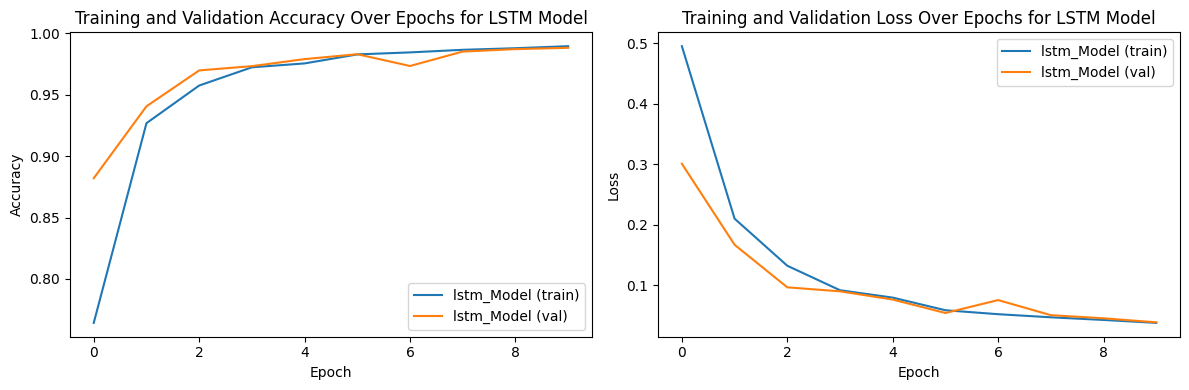

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label=f'lstm_Model (train)')
plt.plot(lstm_history.history['val_accuracy'], label=f'lstm_Model (val)')
plt.title('Training and Validation Accuracy Over Epochs for LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)

plt.plot(lstm_history.history['loss'], label=f'lstm_Model (train)')
plt.plot(lstm_history.history['val_loss'], label=f'lstm_Model (val)')
plt.title('Training and Validation Loss Over Epochs for LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Stacked - Bi-Directional LSTM

In [ ]:
import tensorflow as tf
from keras.layers import Bidirectional, LSTM, Embedding, Dense, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report
import time

# Check if GPU is available and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and memory growth is set.")
    except RuntimeError as e:
        print(e)  # Memory growth must be set at program startup

# Your existing code to calculate class counts, class weights, etc.

# Callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.0001
    )
]

def create_bidirectional_lstm_model(trainable):
    model = Sequential([
        # Embedding Layer
        Embedding(
            input_dim=len(vocabulary),
            output_dim=300,
            input_length=len(df['text'][0]),
            weights=[embedding_matrix],
            trainable=trainable
        ),

        # First Bidirectional LSTM Layer
        Bidirectional(LSTM(128, return_sequences=True,
                           activation='tanh',
                           dropout=0.3)),
        BatchNormalization(),

        # Second Bidirectional LSTM Layer
        Bidirectional(LSTM(64, return_sequences=True,
                           activation='tanh',
                           dropout=0.2)),
        BatchNormalization(),

        # Third Bidirectional LSTM Layer (Final LSTM)
        Bidirectional(LSTM(32, return_sequences=False,
                           activation='tanh',
                           dropout=0.2)),
        BatchNormalization(),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Optimizer with adjusted learning rate
    optimizer = Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train Bidirectional LSTM with fine-tuned embeddings
bidirectional_lstm_model = create_bidirectional_lstm_model(trainable=True)
print("\nBidirectional LSTM Model Summary:")
bidirectional_lstm_model.summary()
start_time = time.time()
bidirectional_lstm_history = bidirectional_lstm_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    # class_weight=class_weights
)

end_time = time.time()

# Evaluate Bidirectional LSTM model
bidirectional_lstm_preds = bidirectional_lstm_model.predict(X_test)
y_pred = (bidirectional_lstm_preds > 0.5).astype(int)
y_true = y_test
print("\nBidirectional LSTM Model Classification Report with fine-tuned embeddings:")
print(classification_report(y_true, y_pred, digits=4))

training_time_bidirectional = end_time - start_time
print(f"Training time: {training_time_bidirectional} seconds")

GPU is available and memory growth is set.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Bidirectional LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      17,915,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,915,400 (68.34 MB)

 Trainable params: 17,915,400 (68.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 191s 380ms/step - accuracy: 0.6305 - loss: 0.6830 - val_accuracy: 0.8625 - val_loss: 0.3321 - learning_rate: 1.0000e-04
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 191s 368ms/step - accuracy: 0.8899 - loss: 0.2902 - val_accuracy: 0.9355 - val_loss: 0.1874 - learning_rate: 1.0000e-04
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 172s 367ms/step - accuracy: 0.9418 - loss: 0.1737 - val_accuracy: 0.9320 - val_loss: 0.1719 - learning_rate: 1.0000e-04
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 368ms/step - accuracy: 0.9560 - loss: 0.1327 - val_accuracy: 0.9696 - val_loss: 0.1005 - learning_rate: 1.0000e-04
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 369ms/step - accuracy: 0.9701 - loss: 0.0942 - val_accuracy: 0.9759 - val_loss: 0.0816 - learning_rate: 1.0000e-04
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 369ms/step - accuracy: 0.9766 - loss: 0.0763 - val_accuracy: 0.9741 - val_loss: 0.0808 - learning_rate: 1.0000e-04
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 

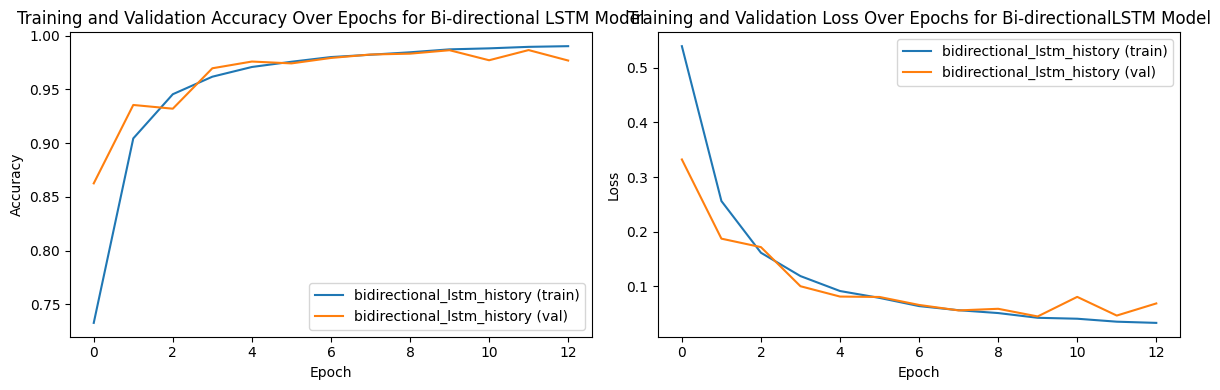

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(bidirectional_lstm_history.history['accuracy'], label=f'bidirectional_lstm_history (train)')
plt.plot(bidirectional_lstm_history.history['val_accuracy'], label=f'bidirectional_lstm_history (val)')
plt.title('Training and Validation Accuracy Over Epochs for Bi-directional LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)

plt.plot(bidirectional_lstm_history.history['loss'], label=f'bidirectional_lstm_history (train)')
plt.plot(bidirectional_lstm_history.history['val_loss'], label=f'bidirectional_lstm_history (val)')
plt.title('Training and Validation Loss Over Epochs for Bi-directionalLSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()